### Let's setup the environment by importing required libraries.

In [2]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
!pip install bs4
!pip install lxml
from bs4 import BeautifulSoup
import csv

!pip install geocoder
import geocoder # to get longitude and latitude

!conda install -c conda-forge folium=0.5.0 --yes
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          98 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0



geopy-2.1.0          | 64 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

In [104]:
url = "https://www.california-demographics.com/cities_by_population"
res = requests.get(url)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))
data.drop(data.columns[[0,2]], axis=1, inplace = True)
new_data = data.head(100)
new_data.head()

,City
0,Los Angeles
1,San Diego
2,San Jose
3,San Francisco
4,Fresno


In [105]:
# Initialize varialbes
lat = []
lng = []
lat_lng_coords = None

# Get postcodes from City table
cs_city = new_data['City']

# Store latitude and longitude values in lat and lng
for nh in cs_city:
    g = geocoder.arcgis('{}, California, US'.format(nh))
    lat_lng_coords = g.latlng
    lat.append(lat_lng_coords[0])
    lng.append(lat_lng_coords[1])

In [106]:
cal_data = new_data
cal_data['Latitude'] = lat
cal_data['Longitude'] = lng

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
cal_data.head()

,City,Latitude,Longitude
0,Los Angeles,34.05361,-118.24550
1,San Diego,32.71568,-117.16171
2,San Jose,37.33865,-121.88542
3,San Francisco,37.77712,-122.41964
4,Fresno,36.74084,-119.78552


### Let's setup FourSquare credentials.

In [108]:
CLIENT_ID = 'C0AICFU55OI040JN5UAXKPFINRYXJNBTLL3XZPFLMV4NVCAM' # your Foursquare ID
CLIENT_SECRET = 'GFU1RE4NXP1HAEI22HPG1ILPEZ3OIHMLSWDEARRJMJS4RUSO' # your Foursquare Secret
VERSION = '20201228'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: C0AICFU55OI040JN5UAXKPFINRYXJNBTLL3XZPFLMV4NVCAM
CLIENT_SECRET:GFU1RE4NXP1HAEI22HPG1ILPEZ3OIHMLSWDEARRJMJS4RUSO


### Now we will get Latitude and Longitude of California.

In [109]:
from geopy.geocoders import Nominatim

address = 'California, US'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of California are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of California are 36.7014631, -118.7559974.


### Let's plot map of California using latitude and longitude values.

In [110]:
cal_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cal_data['Latitude'], cal_data['Longitude'], cal_data['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cal_map)  
    
cal_map

### In the following call we will create a function which will extract the category from the FourSquare vanues. Later we will apply FourSquare API in all the Cities on California.

In [111]:
# Gets the name of the category

def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [112]:
explore_df_list = []

for i, city_name in enumerate(cal_data['City']):  
    
    try :
        #Get City data
        city_name = cal_data.loc[i, 'City']
        city_lat = cal_data.loc[i, 'Latitude']
        city_lng = cal_data.loc[i, 'Longitude']

        radius = 500
        LIMIT = 30 

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, city_lat, city_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flatten JSON

        # Filter the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Rename the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        # Get the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        # Get the required data
        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  # Converts the numpy array to a python list
            f_list = [city_name, city_lat, city_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


### Now we will create a dataframe for performing clustering

In [113]:
explore_cal = pd.DataFrame([item for item in explore_df_list])
explore_cal.columns = ['City', 'City Latitude', 'City Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_cal.head()

,City,City Latitude,City Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Los Angeles,34.05361,-118.2455,Grand Park,Park,34.055034,-118.245179
1,Los Angeles,34.05361,-118.2455,Birds & Bees,Speakeasy,34.052090,-118.247376
2,Los Angeles,34.05361,-118.2455,Badmaash,Indian Restaurant,34.051342,-118.244571
3,Los Angeles,34.05361,-118.2455,Redbird,American Restaurant,34.050666,-118.244068
4,Los Angeles,34.05361,-118.2455,Blue Bottle Coffee,Coffee Shop,34.050881,-118.247952


### Now we will perform one-hot encoding to analyze Cities of California.

In [114]:
cal_1hot = pd.get_dummies(explore_cal[['Venue Category']], prefix="", prefix_sep="")


cal_1hot['City'] = explore_cal['City'] 


fixed_columns = [cal_1hot.columns[-1]] + cal_1hot.columns[:-1].values.tolist()
cal_1hot = cal_1hot[fixed_columns]

cal_1hot.head()

,City,ATM,American Restaurant,Andhra Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pier,Piercing Parlor,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,School,Seafood Restaurant,Shipping Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Los Angeles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Los Angeles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Los Angeles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### In the following step we will agregate the venues by City and later we will create a function to return most common venues.

In [115]:
cal_grouped = cal_1hot.groupby('City').mean().reset_index()
cal_grouped.head()

,City,ATM,American Restaurant,Andhra Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pier,Piercing Parlor,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,School,Seafood Restaurant,Shipping Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Anaheim,0.00,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.033333,0.0,0.0,0.0,0.00,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.033333,0.033333,0.0,0.000000,0.0,0.00,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.066667,0.033333,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0

In [142]:
def top_common_venues(row, top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

### Now we will create a new dataframe to get the top 10 venues.

In [143]:
top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['City']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = cal_grouped['City']

for ind in np.arange(cal_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = top_common_venues(cal_grouped.iloc[ind, :], top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anaheim,Mexican Restaurant,Brewery,Ice Cream Shop,Poke Place,Cajun / Creole Restaurant,Burger Joint,Skating Rink,Southern / Soul Food Restaurant,Speakeasy,Food Court
1,Bakersfield,Chinese Restaurant,Ice Cream Shop,Mexican Restaurant,Coffee Shop,Liquor Store,Event Space,Fondue Restaurant,Flea Market,Fish Market,Fish & Chips Shop
2,Chula Vista,Mexican Restaurant,Brewery,Café,Italian Restaurant,Bakery,Martial Arts School,Seafood Restaurant,Farmers Market,Sushi Restaurant,Beer Bar
3,Concord,ATM,Dog Run,Grocery Store,Park,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant
4,Corona,Convenience Store,Basketball Court,Rental Car Location,Church,Mexican Restaurant,American Restaurant,Hockey Field,Hookah Bar,Flea Market,Fish Market


### Now we will apply K-means clustering on the dataframe.

In [144]:
cal_grouped_clustering = cal_grouped.drop('City', 1)

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [146]:
max_range = 15 #Max range 15 (number of clusters)

from sklearn.metrics import silhouette_samples, silhouette_score


indices = []
scores = []

for cal_clusters in range(2, max_range) :
    
    # Run k-means clustering
    cal_gc = cal_grouped_clustering
    kmeans = KMeans(n_clusters = cal_clusters, init = 'k-means++', random_state = 0).fit_predict(cal_gc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(cal_gc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(cal_clusters)
    scores.append(score)

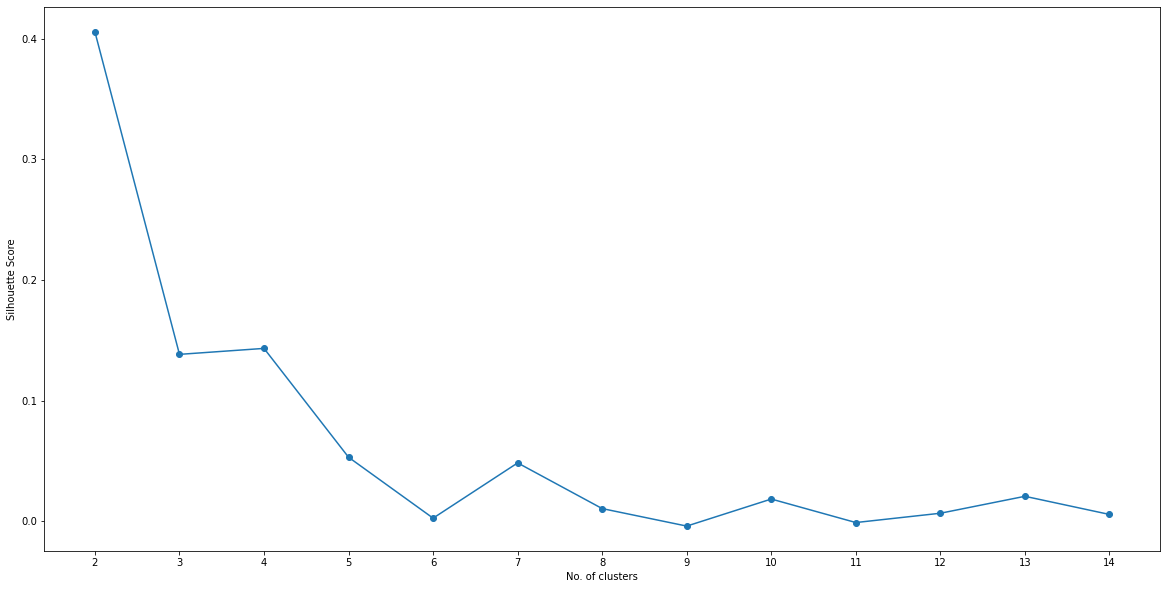

In [147]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

### From the graph the optimal number is found to be 6 using the Elbow Method.

In [148]:
opt_value = 6

### Now that we have calculated out optimum value of clusters, we can proceed with K-Means clustering.

In [149]:
cal_clusters = opt_value

# Run k-means clustering
cal_gc = cal_grouped_clustering
kmeans = KMeans(n_clusters = cal_clusters, init = 'k-means++', random_state = 0).fit(cal_gc)

In [150]:
# Add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

### Now we will crate a final version of dataframe containing all the necessary data.

In [151]:
cal_final = cal_data
cal_final = cal_final.join(city_venues_sorted.set_index('City'), on='City')
cal_final.dropna(inplace = True)
cal_final['Cluster Labels'] = cal_final['Cluster Labels'].astype(int)
cal_final.head()

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Los Angeles,34.05361,-118.24550,2,Art Museum,Coffee Shop,Pizza Place,Plaza,School,Market,Building,Cheese Shop,Speakeasy,Breakfast Spot
1,San Diego,32.71568,-117.16171,2,Hotel,American Restaurant,Seafood Restaurant,Sandwich Place,Sushi Restaurant,Theater,Coffee Shop,Brazilian Restaurant,Theme Restaurant,Lounge
2,San Jose,37.33865,-121.88542,5,Sandwich Place,Mexican Restaurant,Vietnamese Restaurant,Comedy Club,College Cafeteria,Korean Restaurant,Bar,Thai Restaurant,Bakery,Sushi Restaurant
3,San Francisco,37.77712,-122.41964,2,Concert Hall,Poke Place,Coffee Shop,French Restaurant,Gym / Fitness Center,Butcher,Taco Place,Beer Bar,Food & Drink Shop,Boutique
4,Fresno,36.74084,-119.78552,5,Sandwich Place,Museum,Restaurant,Japanese Restaurant,Train Station,Fast Food Restaurant,Grocery Store,Café,Convenience Store,Hotel


### In the next step we will visualize the clusters using Folium.

In [152]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Setup color scheme for different clusters
x = np.arange(cal_clusters)
ys = [i + x + (i*x)**2 for i in range(cal_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(cal_final['Latitude'], cal_final['Longitude'], cal_final['City'], 
                                  cal_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

### Now lets have a look at all four clusters.

In [153]:
val = 1
cal_final.loc[cal_final['Cluster Labels'] == (val - 1), cal_final.columns[[0] + np.arange(4, cal_final.shape[1]).tolist()]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Ontario,ATM,Train Station,Mobile Phone Shop,Burger Joint,Skating Rink,Fast Food Restaurant,Candy Store,Gas Station,Bank,Mexican Restaurant


In [154]:
val = 2
cal_final.loc[cal_final['Cluster Labels'] == (val - 1), cal_final.columns[[0] + np.arange(4, cal_final.shape[1]).tolist()]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Riverside,Performing Arts Venue,Coffee Shop,Bar,Italian Restaurant,Pizza Place,Mexican Restaurant,Bakery,Resort,Sandwich Place,Spa
42,Roseville,Bar,Theater,Pizza Place,Park,American Restaurant,Coffee Shop,Convenience Store,Deli / Bodega,Pub,Donut Shop


In [155]:
val = 3
cal_final.loc[cal_final['Cluster Labels'] == (val - 1), cal_final.columns[[0] + np.arange(4, cal_final.shape[1]).tolist()]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Los Angeles,Art Museum,Coffee Shop,Pizza Place,Plaza,School,Market,Building,Cheese Shop,Speakeasy,Breakfast Spot
1,San Diego,Hotel,American Restaurant,Seafood Restaurant,Sandwich Place,Sushi Restaurant,Theater,Coffee Shop,Brazilian Restaurant,Theme Restaurant,Lounge
3,San Francisco,Concert Hall,Poke Place,Coffee Shop,French Restaurant,Gym / Fitness Center,Butcher,Taco Place,Beer Bar,Food & Drink Shop,Boutique
5,Sacramento,American Restaurant,Hotel,Movie Theater,Coffee Shop,Bar,Thai Restaurant,Building,Bridal Shop,Park,Seafood Restaurant
6,Long Beach,Pizza Place,Ice Cream Shop,Hotel,Plaza,Brewery,Beer Garden,Italian Restaurant,Café,Frozen Yogurt Shop,Sushi Restaurant
7,Oakland,Vegetarian / Vegan Restaurant,Bar,Japanese Restaurant,Café,Taco Place,Food Court,Brazilian Restaurant,Skating Rink,Mexican Restaurant,Seafood Restaurant
9,Anaheim,Mexican Restaurant,Brewery,Ice Cream Shop,Poke Place,Cajun / Creole Restaurant,Burger Joint,Skating Rink,Southern / Soul Food Restaurant,Speakeasy,Food Court
10,Santa Ana,Café,Coffee Shop,Gay Bar,Latin American Restaurant,Furniture / Home Store,Filipino Restaurant,Football Stadium,Brewery,Wine Bar,Home Service
13,Irvine,Hockey Field,Trail,Sporting Goods Shop,Park,Tennis Court,Camera Store,Fountain,Baseball Stadium,Financial or Legal Service,Event Space
14,Chula Vista,Mexican Restaurant,Brewery,Café,Italian Restaurant,Bakery,Martial Arts School,Seafood Restaurant,Farmers Market,Sushi Restaurant,Beer Bar


In [156]:
val = 4
cal_final.loc[cal_final['Cluster Labels'] == (val - 1), cal_final.columns[[0] + np.arange(4, cal_final.shape[1]).tolist()]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Bakersfield,Chinese Restaurant,Ice Cream Shop,Mexican Restaurant,Coffee Shop,Liquor Store,Event Space,Fondue Restaurant,Flea Market,Fish Market,Fish & Chips Shop
12,Stockton,Mexican Restaurant,Coffee Shop,Theater,Rental Car Location,Café,Movie Theater,Filipino Restaurant,Fast Food Restaurant,Sandwich Place,Burger Joint
19,Fontana,Mexican Restaurant,Fast Food Restaurant,Café,Trail,Food,Storage Facility,Seafood Restaurant,Sandwich Place,Fried Chicken Joint,Jewelry Store
20,Oxnard,Mexican Restaurant,Train Station,American Restaurant,Fast Food Restaurant,Sandwich Place,Multiplex,Donut Shop,Burger Joint,Coffee Shop,Thrift / Vintage Store
21,Moreno Valley,Mexican Restaurant,Business Service,BBQ Joint,Thai Restaurant,American Restaurant,Food,Burger Joint,Fish Market,Falafel Restaurant,Fondue Restaurant
30,Corona,Convenience Store,Basketball Court,Rental Car Location,Church,Mexican Restaurant,American Restaurant,Hockey Field,Hookah Bar,Flea Market,Fish Market
38,Torrance,Mexican Restaurant,Performing Arts Venue,Event Space,Sandwich Place,Thai Restaurant,Clothing Store,Deli / Bodega,Theater,Pool,Art Gallery


In [157]:
val = 5
cal_final.loc[cal_final['Cluster Labels'] == (val - 1), cal_final.columns[[0] + np.arange(4, cal_final.shape[1]).tolist()]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Concord,ATM,Dog Run,Grocery Store,Park,Flea Market,Fish Market,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant


In [158]:
val = 6
cal_final.loc[cal_final['Cluster Labels'] == (val - 1), cal_final.columns[[0] + np.arange(4, cal_final.shape[1]).tolist()]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,San Jose,Sandwich Place,Mexican Restaurant,Vietnamese Restaurant,Comedy Club,College Cafeteria,Korean Restaurant,Bar,Thai Restaurant,Bakery,Sushi Restaurant
4,Fresno,Sandwich Place,Museum,Restaurant,Japanese Restaurant,Train Station,Fast Food Restaurant,Grocery Store,Café,Convenience Store,Hotel
16,San Bernardino,Sandwich Place,Fast Food Restaurant,Bank,Grocery Store,Diner,Clothing Store,Movie Theater,Nightclub,Sporting Goods Shop,Convenience Store
17,Santa Clarita,Sandwich Place,Coffee Shop,Cosmetics Shop,Andhra Restaurant,Ice Cream Shop,Pizza Place,Insurance Office,Bank,Grocery Store,Fast Food Restaurant
22,Huntington Beach,Mexican Restaurant,Fast Food Restaurant,Pet Store,Bakery,Spa,Sandwich Place,Chinese Restaurant,Coffee Shop,Juice Bar,Japanese Restaurant
33,Palmdale,Pizza Place,Fast Food Restaurant,Japanese Restaurant,Mexican Restaurant,Convenience Store,Sandwich Place,Performing Arts Venue,Sushi Restaurant,Dance Studio,Recreation Center
34,Salinas,Shipping Store,American Restaurant,Coffee Shop,Fast Food Restaurant,Mexican Restaurant,Bank,Spa,Nightclub,Thai Restaurant,Bakery
35,Sunnyvale,Chinese Restaurant,Grocery Store,Hotel,Bank,Coffee Shop,Fast Food Restaurant,Sandwich Place,Convenience Store,Men's Store,Mexican Restaurant


## After studying all six clusters, Cities that fall in cluster 3 are good locations for starting a new restaurant.
